___
## Attempt to convert osm to geojson failed - how to download maps dynamically?

In [1]:
# min_long = 37.52408
# min_lat = 55.70015
# max_long = 37.54093
# max_lat = 55.70514
# addr = "\"https://api.openstreetmap.org/api/0.6/map?bbox=" \
#     + str(min_long)  + ',' + str(min_lat) + ',' + str(max_long) + ',' + str(max_lat) + '"'

# !curl -o test_map.osm $addr

# import shutil
# import sys
# !mv test_map.osm data
# # with open('data/test_map.osm', encoding='utf-8') as file:
# #     shutil.copyfileobj(file, sys.stdout)

In [2]:
# import codecs
# import osm2geojson
# import geopandas

# with codecs.open('data/test_map.osm', 'r', encoding='utf-8') as data:
#     xml = data.read()

# geojson = osm2geojson.xml2geojson(xml, filter_used_refs=False, log_level='INFO')

# gp.read_file(geojson)

[Parts of the world](http://download.geofabrik.de/)  
[Cities](https://download.bbbike.org/osm/bbbike/)  
[Choose borders](https://extract.bbbike.org/)  
[OSM API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) - possible solution

___
## Using predownloaded map

In [3]:
from parsers.osm_parser import OsmParser

filename = "maps/kozlovo.osm.pbf"
bbox = [35.9, 56.575, 36.12, 56.6]
map_data = OsmParser(filename, bbox)

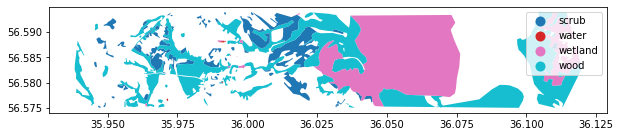

In [4]:
map_data.polygons.plot(column='natural', legend=True, figsize=(10,6));

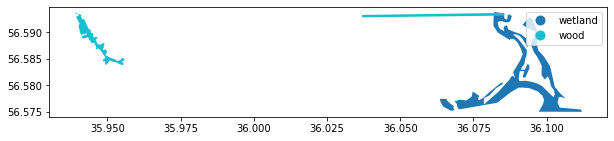

In [5]:
if not map_data.multipolygons.empty:
    map_data.multipolygons.plot(column='natural', legend=True, figsize=(10,6));

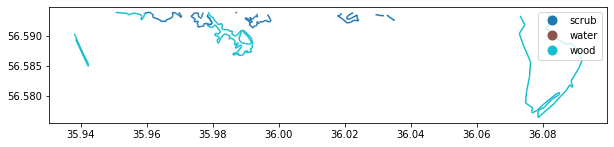

In [6]:
if not map_data.multilinestrings.empty:
    map_data.multilinestrings.plot(column='natural', legend=True, figsize=(10,6));

In [7]:
epsilon = 0.001
bbox_comp = 25
polygons, multilinestrings = map_data.build_dataframe(epsilon, bbox_comp, ellipse=False)

___
## Build a graph

In [8]:
from graph import build_graph, find_pair_cutoff, find_pair_array, find_pair_ellipse
import matplotlib.pyplot as plt
import mplleaflet

In [10]:
%%time
view_angle = 5
G, fig = build_graph(polygons, multilinestrings=multilinestrings, pair_func=find_pair_array,
                     plot=False, view_angle=view_angle, point_approx=False)
print('edges: ', G.number_of_edges())
print('nodes: ', G.number_of_nodes())
# mplleaflet.display(fig=fig)

edges:  554
nodes:  126
CPU times: user 8.23 s, sys: 8.55 ms, total: 8.24 s
Wall time: 8.56 s


<Figure size 432x288 with 0 Axes>

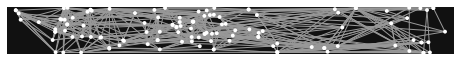

In [11]:
import osmnx as ox
ox.plot_graph(G);

___
Problems:
- A*
___
- Possibly slow convex hull
- Additional natural attributes not in dataframe
- How to store graph?